# Fraud Detection on the Pastel Dataset

This is a financial dataset from __Pastel__, and the goal of the hackathon is to detect fraudulent transactions. However, the number of fraudulent transactions is very little compared to the normal transactions; percentage of the normal being __99.79%__, while that of the fraudulent, __0.21%__. It is a skewed dataset.

So, we are battling with an imbalanced dataset. And there are several methods of resolving this:
- Resampling the dataset: Random Undersampling, Oversampling (SMOTE)
- Collecting more data
- Changing the Performance Metric

And we made use of these methods: we undersampled the dataset, collected the number of normal transactions which is equal to the small number of fraudulent transactions; and because this dataset is small we collected the fraudulent transaction dataset of the credit card dataset, with an equal number of normal transaction dataset. Also, instead of using the Accuracy metric, which will incorrectly measure the performance of our model, we changed that to the metric of __Area Under the Receiver Operating Characteristic Curve, ROC_AUC__.

In [14]:
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler

In [16]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
credit_card = pd.read_csv("creditcard.csv")
sample_sub = pd.read_csv("sample_submission.csv")

In [18]:
train.columns

Index(['id', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Text(0, 0.5, 'Frequency')

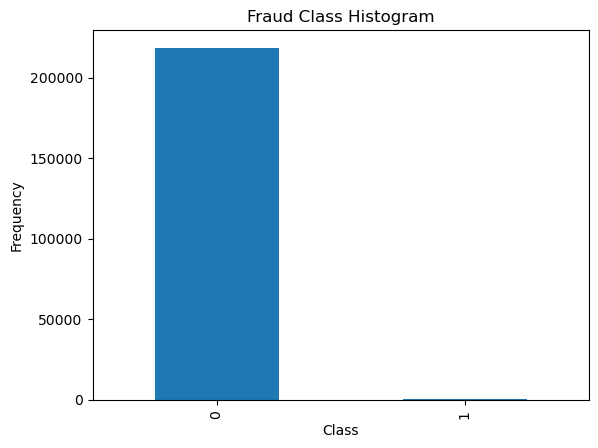

In [70]:
count_classes = pd.value_counts(train['Class'], sort=True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud Class Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

The dataset is highly imbalanced. Therefore, we will not use this dataset as the base of our predictive model, as it will assume that most transactions are not fraud. We want our model to detect patterns that give signs of fraudulent transactions. 

In [75]:
norm_trxn, fraud_trxn = np.unique(train['Class'], return_counts=True)[1]
print(f'Percentage of normal transaction: {round((norm_trxn/len(train))*100, 2)}')
print(f'Percentage of fraudulent transaction: {round((fraud_trxn/len(train))*100, 2)}')

Percentage of normal transaction: 99.79
Percentage of fraudulent transaction: 0.21


## Scaling and Sub Sampling of the Dataset

We will first scale the columns, __Amount__ and __Time__; we normalize them to be on the same scale as other columns.
Also, we will create a sub sample of the datasets to have an equal amount of Fraudulent and Normal cases. This will help the model understand the patterns relating to whether a transaction is fruadulent or not. We will also, augument the sub-sampled dataset with the sample from the credit card dataset.

A __Sub-Sample__ will be a dataframe with a 50/50 ratio of fraudulent and non-fraudulent transactions; using sub-sampled dataset will prevent:
- __Overfitting:__ Where our model will assume that there are no fraud, and incorrectly classify our dataset
- __Wrong Correlations:__ Where we can have a clear correlation of the features of the datasets and how they influence the prediction of fraud.


### Summary
-  __scaled amount__ and __scaled time__ are the scaled columns in the dataset.
- There are __469__ and __492__ fraudulent cases in both __Pastel__ and __Credit Card__ datasets respectively. So we get corresponding __(469 + 492)__ cases of normal cases in both datasets.
- We concatenate the two datasets to get a new sub-sample of __1922__ cases.

In [19]:
rob_scaler = RobustScaler()

t_id = train['id']
train['scaled_amount'] = rob_scaler.fit_transform(train['Amount'].values.reshape(-1,1))
train['scaled_time'] = rob_scaler.fit_transform(train['Time'].values.reshape(-1,1))

train.drop(['Time', 'Amount', 'id'], axis=1, inplace=True)

scaled_amount = train['scaled_amount']
scaled_time = train['scaled_time']

train.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
train.insert(0, 'scaled_amount', scaled_amount)
train.insert(1, 'scaled_time', scaled_time)

In [20]:
train.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.316492,-2.135774,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,-0.292969,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,0
1,0.986654,-2.135774,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,0.065717,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,0
2,-0.305211,-2.135774,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,...,-0.021375,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,0
3,-0.332062,-2.135774,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,...,-0.340089,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,0
4,-0.332062,-2.135774,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,...,-0.203628,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,0


In [21]:
credit_card.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [22]:
credit_card['scaled_amount'] = rob_scaler.fit_transform(credit_card['Amount'].values.reshape(-1,1))
credit_card['scaled_time'] = rob_scaler.fit_transform(credit_card['Time'].values.reshape(-1,1))

credit_card.drop(['Time', 'Amount'], axis=1, inplace=True)

scaled_amount = credit_card['scaled_amount']
scaled_time = credit_card['scaled_time']

credit_card.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
credit_card.insert(0, 'scaled_amount', scaled_amount)
credit_card.insert(1, 'scaled_time', scaled_time)

In [23]:
credit_card.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [24]:
tst_id = test['id']
test['scaled_amount'] = rob_scaler.fit_transform(test['Amount'].values.reshape(-1,1))
test['scaled_time'] = rob_scaler.fit_transform(test['Time'].values.reshape(-1,1))

test.drop(['Time', 'Amount', 'id'], axis=1, inplace=True)

scaled_amount = test['scaled_amount']
scaled_time = test['scaled_time']

test.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
test.insert(0, 'scaled_amount', scaled_amount)
test.insert(1, 'scaled_time', scaled_time)

In [25]:
test.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,0.135977,-1.020092,2.115519,-0.691809,-1.305514,-0.685655,-0.641265,-0.764784,-0.924262,-0.023030,...,0.579121,0.067367,0.241708,0.682524,0.037769,-0.546859,-0.123055,-0.084889,0.004720,-0.021944
1,2.361440,-1.020092,1.743525,-1.681429,-0.547387,-1.061113,-0.695825,2.458824,-1.632859,1.073529,...,-0.066264,0.441788,0.543278,1.294571,0.309541,3.703925,-0.242579,0.068708,0.002629,0.064690
2,-0.096484,-1.020092,2.205568,-1.571445,-0.238965,-1.662517,-1.652324,-0.054701,-1.682064,0.105613,...,0.010671,-0.366906,-0.131527,0.086623,0.291375,0.739087,-0.543006,-0.297813,0.043699,-0.037855
3,1.652891,-1.020092,1.989728,-0.972909,-1.938259,-1.440129,-0.166855,-0.794048,0.252889,-0.399789,...,1.207085,-0.049136,-0.080115,-0.010732,-0.038550,0.656830,0.343470,-0.627529,-0.024338,-0.036143
4,-0.330112,-1.020092,-1.943548,-1.668761,0.363601,-0.977610,2.684779,-2.037681,0.039709,-0.048895,...,-0.267098,0.391627,0.083389,-0.306918,0.247822,-0.391799,-0.790716,-0.025706,0.330758,0.335537


### Random Under-Sampling

Here, we will implement __Random Under Sampling__ which basically consists in creating an equal amount of __Normal__ and __Fraudulent__ cases in the datasets, and removing the excess data cases, in order to have a more balanced dataset and avoid __overfitting__.

__Steps:__
- Bring the __Normal__ transaction datasets to the same amount as __Fraudulent__ transaction sets, this will be equivalent to __(469 + 492)__ cases of normal transactions from both datasets, making a total number of __1922__ cases in the sub-sampled dataset
- After sub-sampling the dataset, we will __reshuffle the dataset__ to see if our models can maintain a certain measure of the performance metric we use, whenver we run our code.

In [26]:
X = train.iloc[:, train.columns != 'Class']
y = train.iloc[:, train.columns == 'Class']

In [27]:
no_record_fraud = len(train[train['Class'] == 1])

fraud_indices = np.array(train[train['Class'] == 1].index)
normal_indices = train[train['Class'] == 0].index
random_normal_indices = np.random.choice(normal_indices, no_record_fraud, replace=False)
random_normal_indices = np.array(random_normal_indices)

under_sample_indices = np.concatenate([random_normal_indices, fraud_indices])

under_sample_data = train.iloc[under_sample_indices,:]

In [29]:
no_record_credit_fraud = len(credit_card[credit_card['Class'] == 1])

fraud_credit_indices = np.array(credit_card[credit_card['Class'] == 1].index)
normal_credit_indices = credit_card[credit_card['Class'] == 0].index
random_normal_credit_indices = np.random.choice(normal_credit_indices, no_record_credit_fraud, replace=False)
random_normal_credit_indices = np.array(random_normal_credit_indices)

undersample_credit_indices = np.concatenate([random_normal_credit_indices, fraud_credit_indices])

undersample_credit_data = credit_card.iloc[undersample_credit_indices,:]

In [30]:
len(under_sample_data), len(undersample_credit_data)

(938, 984)

In [31]:
frames = [under_sample_data, undersample_credit_data]

In [33]:
under_sample_data = pd.concat(frames)

In [34]:
X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

In [35]:
# Showing ratio
from __future__ import division
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  1922


In [36]:
under_sample_data['Class'].value_counts()

0    961
1    961
Name: Class, dtype: int64

In [37]:
under_sample_data = under_sample_data.sample(frac=1)

In [38]:
under_sample_data.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
56284,0.563823,-0.438692,1.191825,-0.148564,-0.367695,-0.033686,-0.196954,-0.866655,0.246898,-0.147495,...,-0.028294,0.046700,-0.052349,-0.195708,0.066159,0.519850,1.117536,-0.133478,-0.015483,0
91669,-0.332062,-0.158960,-0.547002,1.536908,-0.008971,1.099760,1.163819,-0.764134,1.079651,-0.291460,...,0.141547,0.031196,0.084533,-0.059995,-0.191469,-0.392627,-0.282715,0.065284,0.271826,1
219168,0.670020,0.668899,1.873126,-0.653135,-0.628761,0.003430,-0.569327,-0.276042,-0.493417,0.083002,...,-0.112420,-0.191218,-0.630455,0.292076,-0.545274,-0.529712,-0.318852,-0.017213,-0.042684,0
39423,1.602320,-0.527039,-0.702846,0.451283,-0.028331,-2.290591,-0.184045,-0.412803,0.877250,0.325738,...,0.172521,-0.261997,-1.147381,0.342869,-0.888737,-0.487543,-0.486005,-0.047742,0.083333,0
180337,-0.139873,0.467628,-1.559991,1.312366,-0.565189,-0.881588,1.056859,-0.366838,0.527935,0.451948,...,-0.010177,-0.307171,-0.941998,-0.267165,0.100712,-0.085909,0.169737,0.068059,0.137537,0


### Classifiers (Under Sampling):

In this section, we will run two types of classifiers and decide which classifier will be more effective in detecting __fraudulent transactions__. But before that, we have to split our dataset into training and testing sets and separate the features from the labels.

In [40]:
from sklearn.model_selection import train_test_split

X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample,y_undersample, test_size=0.3, random_state = 0)

print("")
print("Number of transactions for train dataset: ", len(X_train_undersample))
print("Number of transactions for test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample) + len(X_test_undersample))


Number of transactions for train dataset:  1345
Number of transactions for test dataset:  577
Total number of transactions:  1922


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

In [102]:
lr = LogisticRegression(solver='liblinear', C = 0.1, random_state=0, penalty='l1')
y_pred_undersample_score= lr.fit(X_train_undersample,y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)
y_pred_undersample_lr = lr.fit(X_train_undersample,y_train_undersample.values.ravel()).predict(X_test_undersample.values)
fpr_lr, tpr_lr, thresholds = roc_curve(y_test_undersample.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr_lr,tpr_lr)
roc_auc_score(y_test_undersample, lr.predict_proba(X_test_undersample)[:,1])

C:\Users\DELL\anaconda33\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\DELL\anaconda33\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.8781422734919491

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

rf = RandomForestClassifier(500, min_samples_leaf=5, min_samples_split=7)
y_pred_undersample_proba_rf= rf.fit(X_train_undersample,y_train_undersample.values.ravel()).predict_proba(X_test_undersample.values)
y_pred_undersample_rf = rf.fit(X_train_undersample,y_train_undersample.values.ravel()).predict(X_test_undersample.values)
fpr_rf, tpr_rf, thresholds = roc_curve(y_test_undersample.values.ravel(),y_pred_undersample_proba_rf[:,1])
roc_auc = auc(fpr_rf,tpr_rf)
roc_auc_score(y_test_undersample, rf.predict_proba(X_test_undersample)[:,1])


C:\Users\DELL\anaconda33\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\DELL\anaconda33\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.9035928863254025

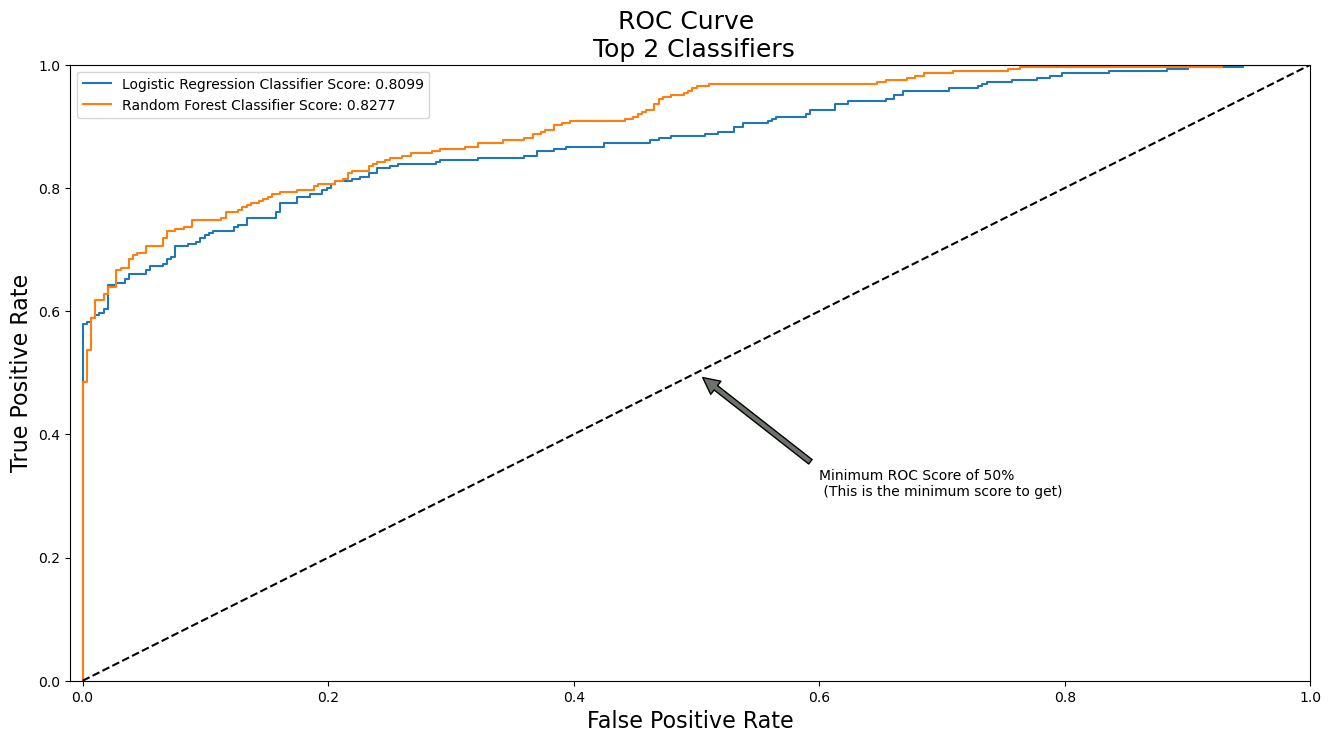

In [104]:
plt.figure(figsize=(16,8))
plt.title('ROC Curve \n Top 2 Classifiers', fontsize=18)
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_test_undersample, y_pred_undersample_lr)))
plt.plot(fpr_rf, tpr_rf, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_test_undersample, y_pred_undersample_rf)))
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
             arrowprops=dict(facecolor='#6E726D', shrink=0.05),
            )
plt.legend()
plt.show()

## Summary

- __Random Forest Classifier__ is a better model among the two models, with a high ROC score of __0.9035__, much better than the __Logistic Regression Classifier__ with ROC score of __0.878__
- __Random Forest Classifier__ shows the best score in both training and testing sets.
- _Random Forests_ are the easies to train, because they are extremely resilient to hyperparameter choices and require very little preprocessing. They are very fast to train, and should not overfit if you have enough trees. 

In [105]:
y_preds = rf.predict_proba(test.values)
y_class = rf.predict(test.values)

C:\Users\DELL\anaconda33\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\DELL\anaconda33\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [106]:
pred_series = np.array([int(x) for x in (y_preds[:,1]>0.5)])

In [58]:
submit = pd.DataFrame({"id": np.array(tst_id), "Class": y_class}, columns=["id","Class"])

In [60]:
submit.to_csv("submission_five.csv", index=False)